### Fine Tuning distilBert

TODO TODO TODO

#### Imports

In [1]:
from datasets import load_dataset, ClassLabel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, TrainingArguments
from peft import LoraConfig, TaskType, PeftModel, get_peft_model
from pathlib import Path
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")
#model name id in hugging face
mdl_tok_name = "distilbert-base-uncased"

#### Test Nvidia CUDA in torch

In [2]:
# Importing required function
import torch

# Check if CUDA is available
if torch.cuda.is_available():
	print(torch.cuda.is_available())
	print(torch.cuda.device_count())
	print(torch.cuda.get_device_name(0))
else:
	print("CUDA is not available on this system. Please ensure that a CUDA-capable device is properly configured.")


True
1
NVIDIA GeForce RTX 4070 Ti


#### Defining Evaluation Metrics as a function

In [3]:
def compute_metrics(eval_pred):
	"""
	Compute evaluation metrics from the given predictions and labels.

	This function accepts an evaluation prediction object containing prediction
	scores and true labels, calculates the relevant classification metrics, and
	returns a dictionary containing these metrics. Metrics computed include
	accuracy, precision, recall, and F1 score.

	:param eval_pred: A tuple containing the predictions and true labels. The
	    predictions are expected as a 2D array where each row contains the
	    probabilistic scores for each class, and true labels are expected as
	    a 1D array of ground truth class indices.
	:return: A dictionary containing the evaluation metrics, with the following
	    keys: "accuracy", "precision", "recall", and "f1".
	:rtype: dict
	"""
	# Unpack predictions and labels
	predictions, labels = eval_pred
	# Get the predicted class (argmax selects the class with the highest score)
	predictions = np.argmax(predictions, axis = 1)
	# Compute metrics
	accuracy = accuracy_score(y_true = labels, y_pred = predictions)
	precision = precision_score(y_true =labels, y_pred =predictions)
	recall = recall_score(y_true = labels, y_pred = predictions)
	f1 = f1_score(y_true = labels, y_pred = predictions)
	# Return all metrics
	return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

#### Creating a confusion matrix visualiation function

In [4]:
def create_confusion_matrix(data, cl_classes, used_trainer ,title_text = 'Confusion Matrix - Validation Set'):
 """
	    Constructs and displays a confusion matrix to evaluate the performance of
	    a classifier on a given dataset, highlighting the relationship between true
	    labels and predicted classifications. The confusion matrix provides insights
	    into label-wise classification accuracy and errors.

	    :param data: A dataset containing the validation data and their corresponding
	        labels in a structure suitable for evaluation.
	    :type data: Any
	    :param cl_classes: A list of possible classification labels (classes) corresponding
	        to the data. Each item in the list represents a unique label of the classification
	        task.
	    :type cl_classes: list
	    :param used_trainer: An object or function used to generate predictions for the given
	        dataset. It must support the required interface or methods to provide predictions
	        or probabilities for the data.
	    :type used_trainer: Any
	    :param title_text: A title for the confusion matrix visualization, used to label
	        the plot for clarity. Defaults to 'Confusion Matrix - Validation Set'.
	    :type title_text: str
	    :return: The generated confusion matrix after the evaluation of the data for
	        comparison with true labels. The matrix format assigns rows to true labels
	        and columns to predicted labels.
	    :rtype: Any
 """
 res = used_trainer.predict(data)
 # Create confusion matrix
 y_true = res.label_ids
 y_pred = res.predictions.argmax(axis=1)
 cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
 # Display the confusion matrix
 disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=cl_classes)
 disp.plot(cmap=plt.cm.Blues)
 plt.title(title_text, pad= 12)
 plt.show()
 return None

#### Loading the filtered dataset

In [5]:
# Define the file path to the dataset
file_path = Path("data/filtered_dataset.csv")

# Load the dataset using Hugging Face's `load_dataset`
dataset = load_dataset('csv', data_files = str(file_path))

# Inspect the unique values in the 'labels' column
product_classes = dataset["train"].unique("Product")

# Convert the 'Product' column to a ClassLabel feature
product_label = ClassLabel(names=product_classes)
dataset = dataset.cast_column("Product", product_label)

# Rename the columns: "Product" to "labels", and "Consumer complaint narrative" to "complaint"
dataset = dataset.rename_column("Product", "labels")
dataset = dataset.rename_column("Consumer complaint narrative", "complaint")

# Extract the features (columns) we want
dataset = \
    dataset["train"].select_columns(
        ["complaint", "labels"]
    ).train_test_split(
        test_size=0.2,
        shuffle=True,
        seed=23,
        stratify_by_column="labels"
    )
splits = ["train", "test"]

# View the resulting dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['complaint', 'labels'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['complaint', 'labels'],
        num_rows: 400
    })
})


#### Inspecting the labels

Credit card or Prepaid Card is labeled as 0 and  Mortgage is labeled as 1

In [6]:
product_label

ClassLabel(names=['Mortgage', 'Credit card or prepaid card'], id=None)

#### Preprocess dataset

Tokenizing 'Consumer complaint narrative' feature values

In [7]:
tokenizer = AutoTokenizer.from_pretrained(mdl_tok_name)

# Let's use a lambda function to tokenize all the examples
tokenized_dataset = {}
for split in splits:
    tokenized_dataset[split] = dataset[split].map(
        lambda x: tokenizer(x["complaint"],
                            truncation=True,
                            padding=True,
                            return_tensors = "pt"
                            ),
	    batched=True,

    )


# Inspect the available columns in the dataset
tokenized_dataset["train"]

Dataset({
    features: ['complaint', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 1600
})

#### Loading Model

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(
    mdl_tok_name,
    num_labels=2,
    id2label={0: "Mortgage", 1: "Credit card or prepaid card"},
    label2id={"Credit card or prepaid card": 0, "Mortgage": 1},
)
print(model)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


#### Initial Evaluation of the model

In [9]:
# Initialize Trainer to use it for evaluation of foundation model
initial_trainer = \
Trainer(
	model = model,
	data_collator = DataCollatorWithPadding(tokenizer=tokenizer),
	tokenizer = tokenizer,
	eval_dataset = tokenized_dataset["test"],
	compute_metrics = compute_metrics
)

# using predict() method to validate the model on the tokenized_dataset["test"] dataset
val_predictions = initial_trainer.predict(tokenized_dataset["test"])
# shape check
print(val_predictions.predictions.shape, val_predictions.label_ids.shape)
# printing the metrics from prediction
print(f"""Metrics:\n{val_predictions.metrics}""")

C:\Users\vtsoumpris\AppData\Local\Temp\ipykernel_29296\2801708475.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  Trainer(


C:\Users\vtsoumpris\PycharmProjects\Lightweight_FineTuning_FoundationModel\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(400, 2) (400,)
Metrics:
{'test_loss': 0.696235179901123, 'test_model_preparation_time': 0.002, 'test_accuracy': 0.5, 'test_precision': 0.0, 'test_recall': 0.0, 'test_f1': 0.0, 'test_runtime': 1.7367, 'test_samples_per_second': 230.323, 'test_steps_per_second': 28.79}


#### Confusion Matrix for the **non** fine-tuned model

C:\Users\vtsoumpris\PycharmProjects\Lightweight_FineTuning_FoundationModel\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


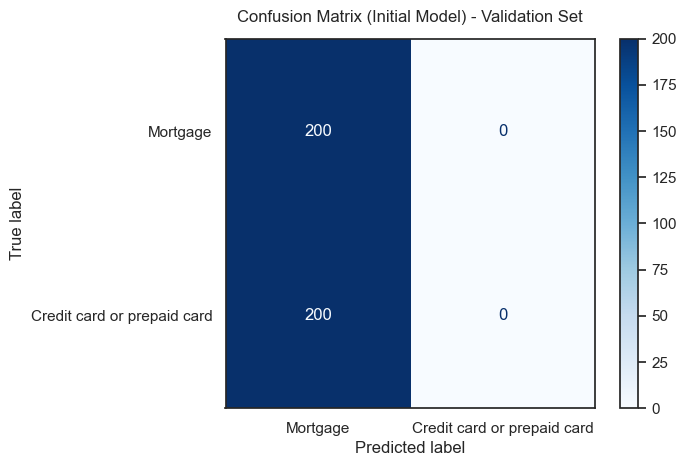

In [10]:
create_confusion_matrix(data = tokenized_dataset["test"],
                        cl_classes= product_classes,
                        used_trainer = initial_trainer,
                        title_text = 'Confusion Matrix (Initial Model) - Validation Set')

#### Lora Configuration for distilBert model

1. **Target Modules is set to:**
    - `q_lin` (query), `k_lin` (key), and `v_lin` (value): The fundamental layers in the attention mechanism crucial for capturing relationships in the inputs.
    - `out_lin`: This layer outputs the processed attention values, making it an important target for parameter-efficient fine-tuning as well.

In [11]:
lora_config = \
	LoraConfig(
		r = 8,  # Low-rank dimension: 8 for a compact model like DistilBERT
		target_modules = ["q_lin", "k_lin", "v_lin", "out_lin"],
		task_type = TaskType.SEQ_CLS,  # Task type, e.g., Sequence Classification
		lora_alpha = 16,  # Scaling factor: smaller due to the lightweight architecture
		lora_dropout = 0.1  # Dropout, increase slightly to prevent overfitting on smaller models
	)

#### Loading foundation model as PEFT model

In [12]:
peft_model = get_peft_model(model, lora_config)
peft_model.print_trainable_parameters()

trainable params: 887,042 || all params: 67,842,052 || trainable%: 1.3075


#### Define Trainer to fine-tune the foundation model

The HuggingFace Trainer class handles the training and eval loop for PyTorch.

You can find more at this [link](https://huggingface.co/docs/transformers/main_classes/trainer).

In [13]:
trainer = Trainer(
    model= peft_model,
    args=TrainingArguments(
        output_dir= "./data/creditc_mortg",
        # Learning rate
        learning_rate= 2e-5,
        # Train/Validate batch size
        per_device_train_batch_size= 16,  # 16: Reduce batch size to avoid memory crashes if needed
        per_device_eval_batch_size= 16, # 16: Same for evaluation
        # Evaluate and save the model after each epoch
        eval_strategy= "epoch", # Evaluate at the end of each epoch
        save_strategy= "epoch", # Save model checkpoint every epoch
	    # Epochs and weight decay
        num_train_epochs= 11,
        weight_decay= 0.01,  # Standard weight decay
	    # Resource management
		gradient_accumulation_steps= 4,  # Simulate larger batches with accumulation
	    #
        load_best_model_at_end= True,
	    use_cpu= False, # Ensure GPU usage
	    seed = 42,
	    data_seed = 42,

	    # Enable logging for losses
	    logging_dir= ".data/logs/distilbert_lora_logs", # dir to save logs
        logging_strategy = "epoch", # log at regular intervals
	    log_level = 'error'
    ),
    train_dataset= tokenized_dataset["train"],
    eval_dataset= tokenized_dataset["test"],
    tokenizer= tokenizer,
    data_collator= DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics= compute_metrics,
)

C:\Users\vtsoumpris\AppData\Local\Temp\ipykernel_29296\2442695433.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


#### Start fine-tuning

In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.687300,0.674217,0.787500,0.732794,0.905000,0.809843
2,0.668100,0.653343,0.862500,0.879581,0.840000,0.859335
3,0.646200,0.627094,0.867500,0.835616,0.915000,0.873508
4,0.616900,0.590212,0.902500,0.888889,0.920000,0.904177
5,0.576700,0.542908,0.912500,0.894737,0.935000,0.914425
6,0.524600,0.485268,0.925000,0.904762,0.950000,0.926829
7,0.468800,0.425928,0.930000,0.901869,0.965000,0.932367
8,0.415100,0.375900,0.935000,0.906542,0.970000,0.937198
9,0.369200,0.340237,0.937500,0.906977,0.975000,0.939759
10,0.344300,0.320016,0.937500,0.906977,0.975000,0.939759


TrainOutput(global_step=275, training_loss=0.5131663964011453, metrics={'train_runtime': 179.0346, 'train_samples_per_second': 98.305, 'train_steps_per_second': 1.536, 'total_flos': 2379386093568000.0, 'train_loss': 0.5131663964011453, 'epoch': 11.0})

#### Final fine-tuned model evaluation metrics

In [15]:
trainer.evaluate()

{'eval_loss': 0.3133885860443115,
 'eval_accuracy': 0.9375,
 'eval_precision': 0.9069767441860465,
 'eval_recall': 0.975,
 'eval_f1': 0.9397590361445783,
 'eval_runtime': 1.6168,
 'eval_samples_per_second': 247.404,
 'eval_steps_per_second': 15.463,
 'epoch': 11.0}

Alternative way to validate the fine-tuned model

In [16]:
# using predict() method to validate the model on the tokenized_dataset["test"] dataset
val_predictions_2 = trainer.predict(tokenized_dataset["test"])
print(val_predictions_2.predictions.shape, val_predictions_2.label_ids.shape)
# printing the metrics from prediction
print(f"""Metrics:\n{val_predictions_2.metrics}""")

(400, 2) (400,)
Metrics:
{'test_loss': 0.3133885860443115, 'test_accuracy': 0.9375, 'test_precision': 0.9069767441860465, 'test_recall': 0.975, 'test_f1': 0.9397590361445783, 'test_runtime': 1.76, 'test_samples_per_second': 227.273, 'test_steps_per_second': 14.205}


#### Saving the model for later use

In [17]:
peft_model.save_pretrained("./vtsoumpris/fnc-distilbert-lora")

#### Printing some of the predictions and the real labels

In [18]:
# Make a dataframe with the predictions and the text and the labels
items_for_manual_review = tokenized_dataset["test"].select(
    [0, 1, 22, 31, 43, 199, 150, 40]
)

results = trainer.predict(items_for_manual_review)
df = pd.DataFrame(
    {
        "complaint": [item["complaint"] for item in items_for_manual_review],
        "predictions": results.predictions.argmax(axis=1),
        "labels": results.label_ids,
    }
)
# Show all the cell
pd.set_option("display.max_colwidth", None)
df

,complaint,predictions,labels
0,"I was offered a secured line of credit with Bank of America. I was asked to pay a deposit of {$200.00}, was told that after a few months, usually 6 months of good payment history, I would get an increase on my credit limit, and that after 12 months, I would get my deposit back. Neither of these promises took place, instead, Bank of America closed my credit line without any previous notice and has never returned my {$200.00} deposit and my payment history is/was excellent. The line of credit has been closed for a few months now and I have yet to received my {$200.00} deposit.",1,1
1,"Bank of America started servicing my Mortgage in XXXX. I had a conventional loan. I received a permanent home modification in XXXX. My loan has always been in good standing and was never deliquent. I modified the loan to get a lower interest rate. Apparently Bank of America made some mistakes during this process of the modification and I had to do the Modification over again. In XXXX Bank of Americaa sold my loan to a Dept Collection Agency named XXXX. This company has unscrupolus business practices that has caused emotional and financial harm to me. In XXXX, XXXX, I began to make my contractual mortgage payments to XXXX as my new servicer in the amount of {$620.00}. XXXX immediately claimed I missed a payment to Bank of Americia on XXXX XXXX and begin to harrass me on my cell phone demanding that I pay them. I told them I had never missed a payment with Bank of America and why would they concern themselfs with my Morgage with Bank of America 2 year prior to them taking over my loan? XXXX claimed they paid Bank of America the missing funds on XXXX XXXX, XXXX and begin to charge me late fees and evenutlly cause my loan to go into Foreclosure. XXXX also increased my Mortgage amount from {$620.00} to {$790.00} stating I had a shortage in Escorws without properly notifying me of the large increase. When I paid the amount I was contracted to pay, XXXX put my mortgage payment in a suspense account stating they do not take partial payments. XXXX begain to add late fees, unauthorized inspection fees and demanded full payment and threatend to start legal procedures of foreclosure. I contacted XXXX representatives in XXXX week trying to resolve this proplem. XXXX did XXXX escrow analysis from XXXX XXXX to XXXX, XXXX and each time my escow shortage changed with each representative. I contacted Bank of America and aske them if they have any knowledge of a missed payment and they said no. I asked Bank of America to fax over my payment history which they did and there was no record of a missed payment. XXXX continued to harrass me as a collection agency does. I was confused about how my mortgage having been serviced by a professional and reputable company such as Bank of America could go from excellent payment history to Foreclosure in a matter of 4 months. I was so distraught I reached out to my brother for support that perhaps I was somehow making a mistake. He looked at my banking records from XXXX XXXX Bank and Bank of America 's record and he too found no missing payments and he wrote the CEO of the Company and filed a complaint that XXXX was falsesifying records to delibertly cause my loan to be in default, however, XXXX 's investigation found no errors and reported my loan deliquent to the credit bureau and I was disqulified from receiving my {$5000.00} inscentive payment for keeping my loan in good standing. After much grief dealing with a Criminal company, I reached out to the XXXX office to file a complaint against XXXX and discovered XXXX is not a bank at all they are a fly by night collection company. Bank of America has no documentation of XXXX ever sending them funds on XXXX XXXX and there is no missing payment. XXXX is running scams on their customers and there is plenty documentatiion as such. My loan should have never went to a collection agency and XXXX uses off shore agents to handle mortgages and unauthorized 

#### Creating the confusion matrix of the fine-tuned model

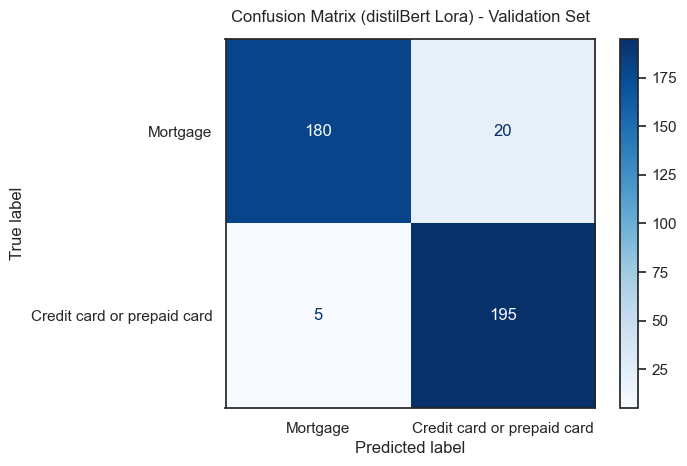

In [19]:
create_confusion_matrix(data = tokenized_dataset["test"],
                        cl_classes= product_classes,
                        used_trainer = trainer,
                        title_text = 'Confusion Matrix (distilBert Lora) - Validation Set')

#### Loading the fine-tuned peft model and validating on the test data

In [22]:
#Loading the model
from peft import AutoPeftModelForSequenceClassification
path = "./vtsoumpris/fnc-distilbert-lora"

LoRA_model = AutoPeftModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path = path)

KeyboardInterrupt: 

In [ ]:
# passing the LoRA_model as the new model parameter for the previously created trainer
trainer.model = LoRA_model
trainer.model.to("cuda")

In [ ]:
trainer.evaluate()

In [ ]:
val_predictions.metrics

In [19]:
print(torch.cuda.memory_summary(device = None, abbreviated = False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 289690 KiB |   2676 MiB |  12328 GiB |  12328 GiB |
|       from large pool | 285952 KiB |   2662 MiB |  12248 GiB |  12248 GiB |
|       from small pool |   3738 KiB |     15 MiB |     80 GiB |     80 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 289690 KiB |   2676 MiB |  12328 GiB |  12328 GiB |
|       from large pool | 285952 KiB |   2662 MiB |  12248 GiB |